In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from prophet import Prophet
import joblib


In [3]:
# Filtrando o avisos
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('Dataset.csv')

## Entendendo os dados 

In [5]:
# Mostrando informações gerais sobre o dataframe
print("\nInformações gerais sobre o dataset:")
print(df.info())

# Mostrando estatísticas descritivas das colunas numéricas
print("\nEstatísticas descritivas das colunas numéricas:")
print(df.describe())

# Mostrando estatísticas descritivas das colunas categóricas
print("\nEstatísticas descritivas das colunas categóricas:")
print(df.describe(include=['O']))

# Verificando valores nulos
print("\nValores nulos no dataset:")
print(df.isnull().sum())

# Mostrando as primeiras linhas do dataframe
print("Primeiras linhas do dataset:")
print(df.head())


Informações gerais sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

Estatísticas descritivas das colunas numéricas:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000


### 1. Tratamento de dados

In [6]:
# Tratar valores nulos
df['Description']=df['Description'].fillna('Descrição Indisponível')

# Remover registros com CustomerID nulo, se necessário
df = df.dropna(subset=['CustomerID'])

df = df.drop_duplicates()

# Filtrando valores negativos
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Converter InvoiceDate para datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['InvoiceNo'] = df['InvoiceNo'].astype(int)

In [7]:
# Mostrar as estatísticas básicas após limpeza
print("Informações gerais sobre o dataset após limpeza:")
print(df.info())

print("\nEstatísticas descritivas das colunas numéricas após limpeza:")
print(df.describe())

print("\nEstatísticas descritivas das colunas categóricas após limpeza:")
print(df.describe(include=['O']))

print("\nValores nulos no dataset após limpeza:")
print(df.isnull().sum())

Informações gerais sobre o dataset após limpeza:
<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  int32         
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(3)
memory usage: 25.5+ MB
None

Estatísticas descritivas das colunas numéricas após limpeza:
           InvoiceNo       Quantity                    InvoiceDate  \
count  392692.000000  392692.000000                         392692   
mean   560590.875047      13.119702  2011-07-10

### 2. Detecção de Anomalias

    Pergunta: Existem transações suspeitas ou anômalas nas vendas?
    Tarefa: Desenvolver um modelo para detectar transações anômalas no dataset. Considerar fatores como quantidade, preço unitário e preço total para identificar possíveis fraudes ou erros.

In [8]:
# Criando coluna 'TotalPrice'
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

from sklearn.ensemble import IsolationForest

# Selecionando apenas colunas numéricas para detecção de anomalias
features = df[['Quantity', 'UnitPrice','TotalPrice','CustomerID']]

# Treinando modelo de Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['Anomalia'] = iso_forest.fit_predict(features)

# Identificando transações anômalas
anomalias = df[df['Anomalia'] == -1]

df=df.drop(anomalias.index)


# Com base nos resultados das análises, foram extraídos insights valiosos que podem ser aplicados para melhorar as estratégias de marketing, otimização de estoque e retenção de clientes.

## 1. Análise das vendas

    Pergunta: Qual é a tendência de vendas ao longo do tempo?
    Tarefa: Analisar as vendas mensais ao longo dos anos disponíveis no dataset. Criar gráficos que mostrem a tendência de vendas, identifique padrões sazonais ou variações significativas e no final criar um modelo para previsão de vendas.


Tendência Mensal de Vendas:
InvoiceDate
2010-12-31    455005.950
2011-01-31    384335.630
2011-02-28    364337.240
2011-03-31    474068.460
2011-04-30    380050.341
2011-05-31    539341.380
2011-06-30    483358.110
2011-07-31    470964.071
2011-08-31    496857.410
2011-09-30    737774.532
2011-10-31    785500.840
2011-11-30    972938.380
2011-12-31    271564.840
Freq: ME, Name: TotalPrice, dtype: float64


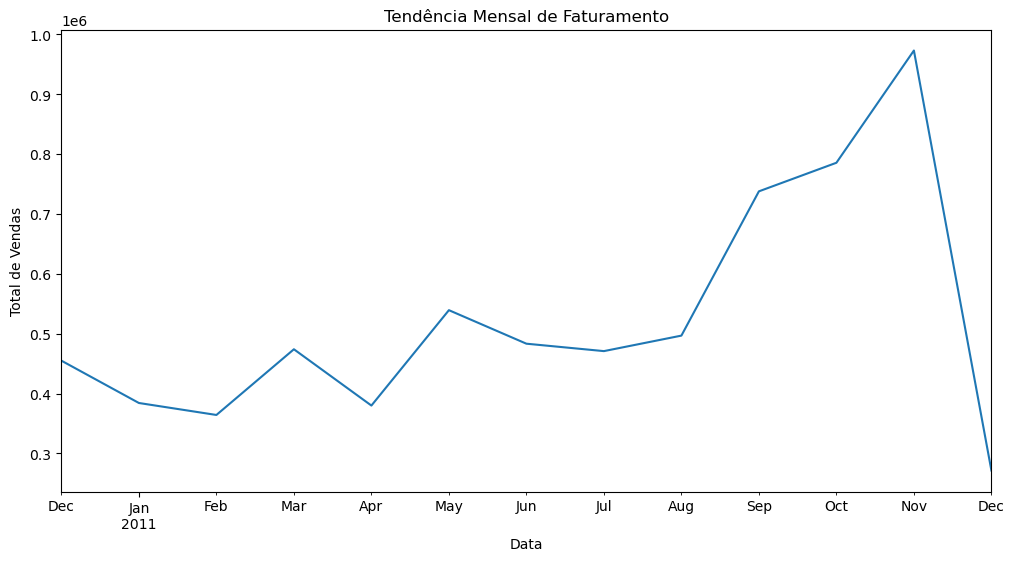


Top 10 Produtos mais Vendidos:
                           Description  Quantity
0              JUMBO BAG RED RETROSPOT     30008
1    WORLD WAR 2 GLIDERS ASSTD DESIGNS     24751
2   WHITE HANGING HEART T-LIGHT HOLDER     23106
3        ASSORTED COLOUR BIRD ORNAMENT     23015
4      PACK OF 72 RETROSPOT CAKE CASES     22870
5      VICTORIAN GLASS HANGING T-LIGHT     17598
6              LUNCH BAG RED RETROSPOT     16826
7                       POPCORN HOLDER     15527
8  COLOUR GLASS T-LIGHT HOLDER HANGING     15203
9              JUMBO BAG PINK POLKADOT     13748

Tendência Mensal de Faturamento dos 10 produtos mais vendidos:
MesAno                               2010-12  2011-01  2011-02  2011-03  \
Description                                                               
ASSORTED COLOUR BIRD ORNAMENT        2724.59  2240.19  1924.91  3069.98   
COLOUR GLASS T-LIGHT HOLDER HANGING   280.80   330.00   468.45   653.60   
JUMBO BAG PINK POLKADOT               483.60  1243.35  1253.55  2

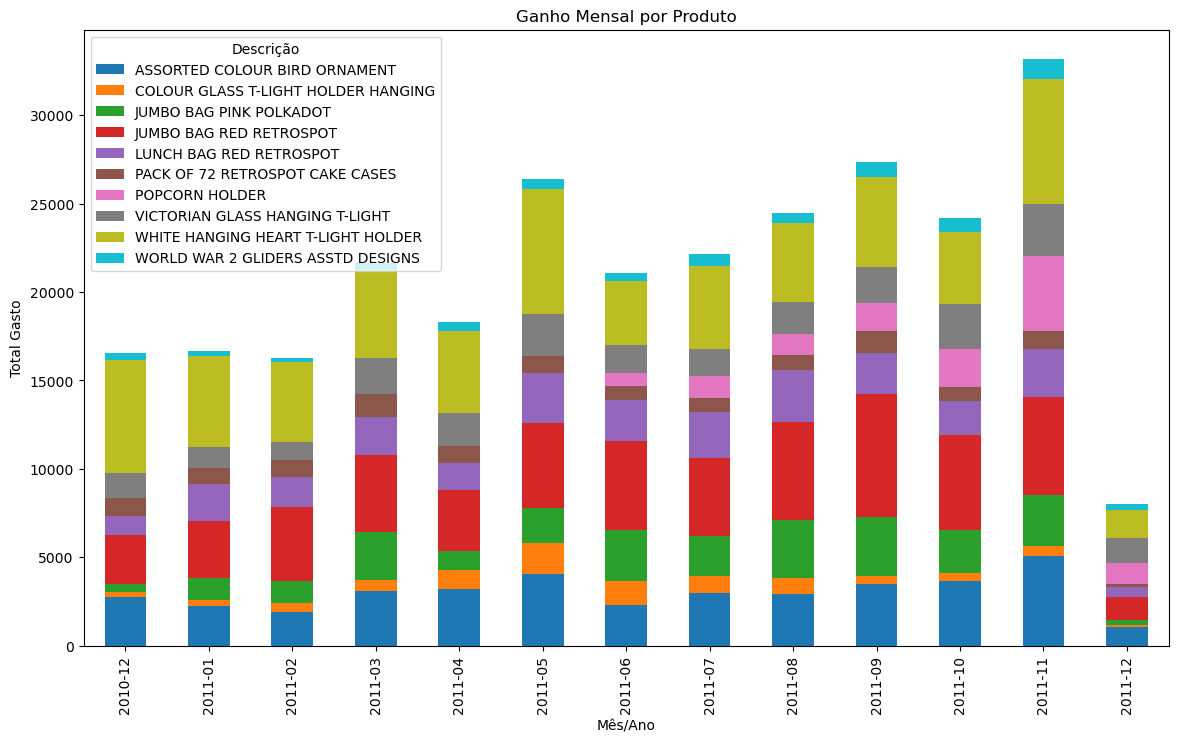

In [9]:
# Análise de Tendências de Produtos
faturamento_mensal = df.resample('M', on='InvoiceDate')['TotalPrice'].sum()
print("\nTendência Mensal de Vendas:")
print(faturamento_mensal)

# Gráfico de Tendência de Faturamento
plt.figure(figsize=(12,6))
faturamento_mensal.plot(kind='line')
plt.title('Tendência Mensal de Faturamento')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.show()

# Tendência Mensal de Vendas dos 10 produtos mais vendidos
top10 = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).reset_index().head(10)
#Retirei o top 1 por se tratar de um outlier(Provável Fraude)
print("\nTop 10 Produtos mais Vendidos:")
print(top10)

df_aux=df[['Description','Quantity','InvoiceDate','TotalPrice']]
df_aux=df_aux[df_aux['Description'].isin(top10['Description'])]
# Criar uma coluna para o mês e ano
df_aux['MesAno'] = df_aux['InvoiceDate'].dt.to_period('M')

# Agrupando por descrição e mês/ano e somar os preços
mais_vendidos = df_aux.groupby(['Description', 'MesAno'])['TotalPrice'].sum().unstack(fill_value=0)
print("\nTendência Mensal de Faturamento dos 10 produtos mais vendidos:")
print(mais_vendidos)

# Plotando o gráfico
mais_vendidos.T.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Ganho Mensal por Produto')
plt.xlabel('Mês/Ano')
plt.ylabel('Total Gasto')
plt.legend(title='Descrição')
plt.show()

### Tendência mensal de vendas

    Insight: As vendas tendem a aumentar significativamente em novembro, possivelmente devido às compras de fim de ano.
    Ação: Preparar estoque adicional e lançar campanhas de marketing antecipadas para aproveitar o aumento nas vendas durante esses meses. Oferecer promoções especiais e descontos progressivos para maximizar as vendas.
        
### Top 10 Produtos mais Vendidos

    Insight: Produtos como "JUMBO BAG RED RETROSPOT" e "WORLD WAR 2 GLIDERS ASSTD DESIGNS" são os mais vendidos, com grandes quantidades.
    Ação: Assegurar que esses produtos estejam sempre em estoque e considerar expandir a linha de produtos relacionados a eles. Além disso, destacá-los em campanhas de marketing e nas páginas de destino do site.
        
### Tendência Mensal de Vendas dos 10 Produtos mais Vendidos

    Insight: Há um produto, como "POPCORN HOLDER", que começam a ser vendidos a partir de junho, enquanto outros têm vendas mais constantes.
    Ação: Planejar o estoque com base nas tendências de venda de cada produto. Para produtos com picos sazonais, garantir maior disponibilidade durante esses períodos específicos.
    
### Campanhas Sazonais e de Festividades
        
    Insight: Identificar picos sazonais de vendas pode ajudar a planejar campanhas de marketing mais eficazes.
    Ação: Criar campanhas de marketing específicas para eventos sazonais e festividades, aproveitando os picos naturais de vendas. Por exemplo, campanhas de Natal, Black Friday, ou outros feriados relevantes.

### Lista de produtos menos vendidos e que podem ser descontinuados:

In [10]:
df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).reset_index().tail(20)['Description'].tolist()

['EASTER CRAFT IVY WREATH WITH CHICK',
 "NEW BAROQUE B'FLY NECKLACE PINK",
 'JARDIN ETCHED GLASS BUTTER DISH',
 'JADE CRYSTAL+GLASS BRACELET',
 'BLOSSOM IMAGES SCRAP BOOK SET',
 'FLOWER SHOP DESIGN MUG',
 'CAPIZ CHANDELIER',
 'PINK CRYSTAL GUITAR PHONE CHARM',
 'MIDNIGHT BLUE CRYSTAL DROP EARRINGS',
 'DOLPHIN WINDMILL',
 'SET OF 3 PINK FLYING DUCKS',
 'AMBER BERTIE GLASS BEAD BAG CHARM',
 'PURPLE FRANGIPANI HAIRCLIP',
 'CAKE STAND LACE WHITE',
 'RUBY GLASS CLUSTER EARRINGS',
 'SET/3 FLORAL GARDEN TOOLS IN BAG',
 'VINTAGE POST OFFICE CABINET',
 'AMBER GLASS/SHELL/PEARL NECKLACE',
 'DUSTY PINK CHRISTMAS TREE 30CM',
 'SET 10 CARDS HANGING BAUBLES 17080']

### Previsão de Faturamento

    Pergunta: Como será o faturamento no próximo mês?
    Tarefa: Construir um modelo de previsão de faturamento para prever o faturamento do mês seguinte. Utilizar técnicas de séries temporais e validar a acurácia do modelo com dados históricos.

In [11]:
vendas_dia = df.resample('d', on='InvoiceDate')['TotalPrice'].sum()
df_previsao = pd.DataFrame({'ds' : vendas_dia.index, 'y' : vendas_dia.values})

m = Prophet()
m.fit(df_previsao)

18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
## Cálculo do erro médio

In [13]:
from sklearn.metrics import mean_absolute_error
previsao = m.predict(df_previsao)
previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
mean_absolute_error(df_previsao.y, previsao.yhat)

5510.265503451185

Com base nas datas passadas o previsor erra em média 5 mil acima ou abaixo do fatumento real

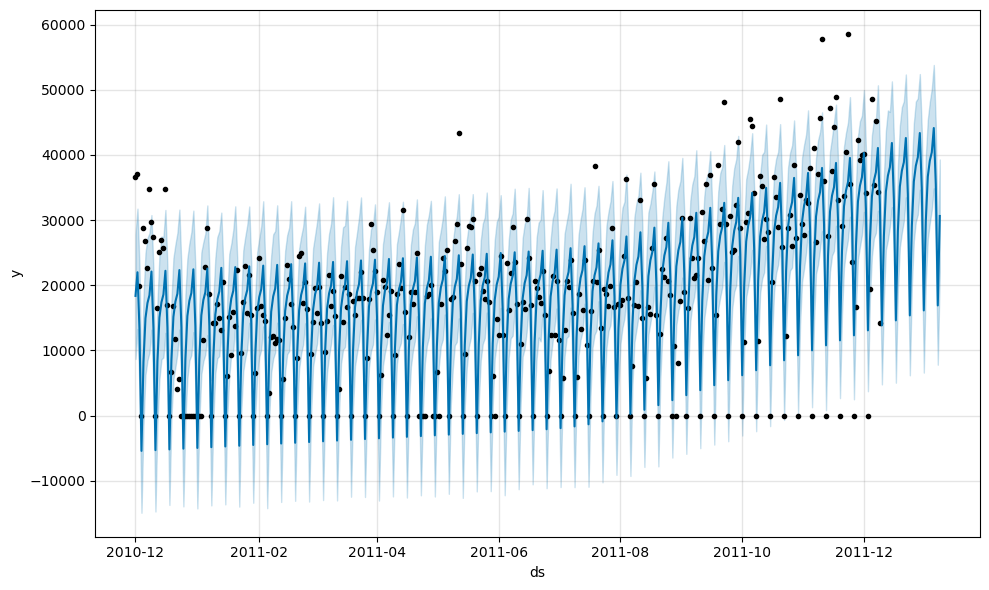

In [14]:
## Previsão real
datas_e_futuro = m.make_future_dataframe(periods=30)
previsao = m.predict(datas_e_futuro)
previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(previsao)

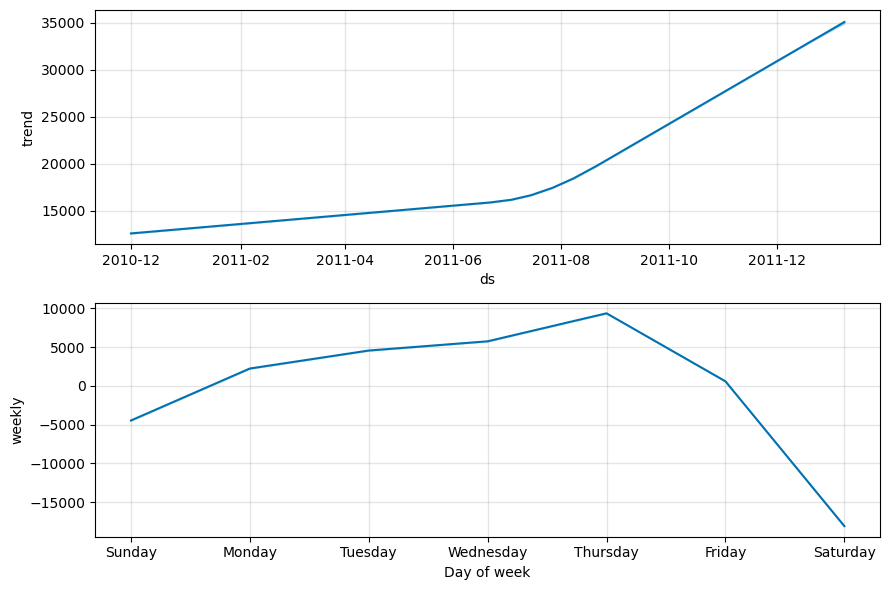

In [15]:
fig2 = m.plot_components(previsao)

Os gráficos de sazonalidade do previsor mostram o aumento de vendas no final do ano (dando razão a análise passada) e a queda de vendas na segunda-feira.

In [16]:
proximo_mes = np.round(previsao.resample('M', on='ds')['yhat'].sum().tail(1)[0],2)
print(f'Previsão de Faturamento para o próximo mês: {proximo_mes}')

Previsão de Faturamento para o próximo mês: 273201.48


## 2. Segmentação de Clientes

    Pergunta: Quais são os diferentes segmentos de clientes baseados no valor de suas compras?
    Tarefa: Utilizar técnicas para segmentar os clientes com base nas suas compras. Identificar e descrever os diferentes segmentos encontrados.

In [17]:
# Customer Lifetime Value (CLV, total gasto por cliente) 
clv = df.groupby('CustomerID')['TotalPrice'].sum()
print("\nTop 10 CLV (Customer Lifetime Value):")
print(clv.sort_values(ascending=False).head(10))


Top 10 CLV (Customer Lifetime Value):
CustomerID
14646.0    174579.08
14911.0    131651.19
17511.0     72608.76
14156.0     62559.07
15311.0     60103.79
13089.0     53992.71
14096.0     53384.80
14298.0     48191.39
12415.0     47333.89
14088.0     46507.82
Name: TotalPrice, dtype: float64


### Customer Lifetime Value (CLV)        
    
    Insight: Clientes de alto CLV, como o cliente 14646.0, geram receitas significativamente maiores.
    Ação: Além de programas VIP, realizar entrevistas ou pesquisas com esses clientes para entender melhor suas necessidades e preferências. Utilizar essas informações para personalizar ainda mais suas ofertas e campanhas.

### Análise de Canais de Aquisição de Clientes
        
    Insight: Entender quais canais de marketing trazem mais clientes valiosos (com alto CLV).
    Ação: Alocar mais recursos nos canais de aquisição mais eficazes (como publicidade paga, marketing de conteúdo, redes sociais) e otimizar ou descontinuar canais menos eficazes.

In [18]:
# Definindo a última data do dataset
ultima_data = df['InvoiceDate'].max()

# Segmentação RFM
df['Recencia'] = (ultima_data - df.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days
df['Frequencia'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')
df['Monetario'] = df.groupby('CustomerID')['TotalPrice'].transform('sum')

# Classificação RFM
rfm = df.groupby('CustomerID').agg({
    'Recencia': 'min',
    'Frequencia': 'max',
    'Monetario': 'max'
}).reset_index()

# Categorização RFM
rfm['R_Score'] = pd.qcut(rfm['Recencia'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequencia'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetario'], 4, labels=[1, 2, 3, 4])
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

rfm.sort_values('RFM_Score', ascending=False)

,CustomerID,Recencia,Frequencia,Monetario,R_Score,F_Score,M_Score,RFM_Score
0,12347.0,1,7,4060.40,4,4,4,12
450,12935.0,1,7,2160.70,4,4,4,12
1575,14505.0,16,8,5859.43,4,4,4,12
1576,14506.0,16,5,1960.65,4,4,4,12
1583,14515.0,17,6,2076.89,4,4,4,12
...,...,...,...,...,...,...,...,...
2138,15279.0,354,1,290.51,1,1,1,3
2139,15280.0,171,1,113.12,1,1,1,3
655,13226.0,272,1,108.21,1,1,1,3
2147,15292.0,200,1,178.39,1,1,1,3


### Segmentação RFM

    Insight: A análise RFM permite identificar segmentos distintos de clientes, como clientes frequentes (ex.: CustomerID 18283.0) e clientes de alto valor mas pouco frequentes.
    Ação: Desenvolver estratégias de marketing específicas para cada segmento. Por exemplo, para clientes com alta frequência mas menor valor monetário, oferecer pacotes de produtos; para clientes de alto valor mas pouca frequência, enviar amostras de novos produtos ou descontos exclusivos.

###  Análise de Frequência de Compras
        
    Insight: Clientes com alta frequência de compra são importantes para a receita contínua.
    Ação: Criar um programa de assinatura ou recompensas para incentivar compras frequentes. Oferecer descontos para compras recorrentes ou assinaturas mensais/anuais de produtos.

## 3. Análise de Churn de Clientes

    Pergunta: Quais clientes têm maior probabilidade de deixar de comprar na nossa plataforma?
    Tarefa: Verificar a quantidade de clientes churned e desenvolver um modelo preditivo para identificar clientes com maior probabilidade de churn (desistência). Utilizar variáveis como frequência de compra, valor total gasto.

In [19]:
# Análise de Churn de Clientes
# Calcular o tempo desde a última compra de cada cliente
df['UltimaCompra'] = df.groupby('CustomerID')['InvoiceDate'].transform('max')
df['DiaDaUltimaCompra'] = (ultima_data - df['UltimaCompra']).dt.days

#ID dos clientes churned
churn = df[df['DiaDaUltimaCompra'] > 90]['CustomerID'].unique().tolist() # Definindo um limiar para considerar churn (90 dias sem compra)
#Quantidade de clientes churned
df[df['DiaDaUltimaCompra'] > 90]['CustomerID'].nunique()

1428



    Número de clientes churned: 1428

    Insight: O número significativo de clientes que não compraram nos últimos 90 dias sugere a necessidade de estratégias de reengajamento. Campanhas de marketing direcionadas, programas de fidelidade e ofertas personalizadas podem ajudar a reduzir o churn.
    Ação: Implementar campanhas de e-mail marketing para clientes inativos, oferecendo descontos exclusivos ou novidades que possam interessá-los.



### Criação do Modelo

In [20]:
# Criando a coluna 'churn' no DataFrame rfm
rfm['churn'] = rfm['CustomerID'].apply(lambda x: 1 if x in churn else 0)

#rfm

In [21]:
from imblearn.over_sampling import SMOTE

# Criando uma instância do SMOTE
smote = SMOTE(random_state=42)

# Balanceando os dados
X, y = smote.fit_resample(rfm[['Recencia','Frequencia','Monetario']], rfm.iloc[:, 8])
X = X[['Frequencia','Monetario']]
# Retirei a coluna recência para evitar overfitting
# Usei a recência no balanceamento para o algoritmo entender melhor padrões e isso resultou em um aumento de 2% na precisão em comparação a somente as 2 outras colunas 

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Validação Cruzada Estratificada
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, val_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]
     

clf = GradientBoostingClassifier(random_state=42,loss='exponential')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print("="*60)
    


              precision    recall  f1-score   support

           0       0.76      0.63      0.69       286
           1       0.68      0.80      0.74       286

    accuracy                           0.72       572
   macro avg       0.72      0.72      0.71       572
weighted avg       0.72      0.72      0.71       572



In [23]:
# Definindo os valores possíveis para cada coluna
frequencia_values = np.random.randint(1, 6, size=10)
monetario_values = np.random.randint(100, 1001, size=10)

# Criando o DataFrame
teste_aleatorio = pd.DataFrame({
    'Frequencia': frequencia_values,
    'Monetario': monetario_values
})

In [24]:
# Salvando o modelo
#joblib_file = "desistencia_modelo.pkl"
#joblib.dump(clf, joblib_file)

In [25]:
# Carregando o modelo salvo
desistencia = joblib.load("desistencia_modelo.pkl")

Testando modelo com dados criados aleatoriamente

In [26]:
# Definindo os valores possíveis para cada coluna
frequencia_values = np.random.randint(1, 6, size=10)
monetario_values = np.random.randint(100, 1001, size=10)

# Criando o DataFrame
teste_aleatorio = pd.DataFrame({
    'Frequencia': frequencia_values,
    'Monetario': monetario_values
})

In [27]:
# Fazendo previsões
print(f"Previsões para os seguintes dados:\n\n{teste_aleatorio.tail(1).to_string(index=False)}\n\nChance de não comprar mais: {desistencia.predict_proba(teste_aleatorio.tail(1))[:, 1][0] * 100:.2f}%")

Previsões para os seguintes dados:

 Frequencia  Monetario
          3        701

Chance de não comprar mais: 34.19%


## 4. Recomendação de Produtos

    Pergunta: Quais produtos devemos recomendar para nossos clientes?
    Tarefa: Criar um sistema de recomendação que sugira produtos para os clientes com base em suas compras passadas e encontrar produtos frequentemente comprados juntos usando regras de associação pois podem ser combinados em pacotes ou promoções.

In [28]:
# Análise de Cesta de Compras
lista_apriori = df.groupby('InvoiceNo')['Description'].apply(list).tolist()

# Pré-Processamento
te = TransactionEncoder()
data_te = te.fit(lista_apriori).transform(lista_apriori)
#data_te
#te.columns_
df_apriori = pd.DataFrame(data_te, columns=te.columns_)
#df_apriori.head()

# Buscando itens que aparecem juntos em pelo menos 1% dos dados
frequent_itemsets = apriori(df_apriori, min_support = 0.01, use_colnames=True, low_memory=True)
#frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
#frequent_itemsets=frequent_itemsets[frequent_itemsets['length'] >= 2]
#frequent_itemsets

regras = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)
regras=regras.sort_values(by=['lift'], ascending = False).drop(['antecedent support', 'consequent support', 'leverage', 'conviction','zhangs_metric'], axis=1)

regras

,antecedents,consequents,support,confidence,lift
17,"(REGENCY TEA PLATE GREEN , REGENCY TEA PLATE R...",(REGENCY TEA PLATE PINK),0.010276,0.814978,65.500216
20,(REGENCY TEA PLATE PINK),"(REGENCY TEA PLATE GREEN , REGENCY TEA PLATE R...",0.010276,0.825893,65.500216
19,"(REGENCY TEA PLATE ROSES , REGENCY TEA PLATE P...",(REGENCY TEA PLATE GREEN ),0.010276,0.939086,63.083472
4,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.011220,0.901786,60.577792
18,"(REGENCY TEA PLATE GREEN , REGENCY TEA PLATE P...",(REGENCY TEA PLATE ROSES ),0.010276,0.915842,50.576368
15,"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ...",(POPPY'S PLAYHOUSE BEDROOM ),0.010332,0.865116,49.286989
6,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE ROSES ),0.010943,0.879464,48.567471
7,(SET/10 BLUE POLKADOT PARTY CANDLES),(SET/10 PINK POLKADOT PARTY CANDLES),0.010054,0.808036,48.490223
16,"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...",(POPPY'S PLAYHOUSE KITCHEN),0.010332,0.907317,47.209333
5,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE ROSES ),0.012609,0.847015,46.775490


### Análise de Cesta de Compras
    Regra de Associação: Foi configurado para produtos que aparacem pelo menos em 1% dos dados sendo comprados juntos e com probabilidade de pelo menos 80% de serem comprados juntos (Essa configuração pode ser alterada)

    Insight: Produtos como "REGENCY TEA PLATE PINK" e "REGENCY TEA PLATE GREEN" são frequentemente comprados juntos. Isso indica potencial para pacotes de produtos.
    Ação: Criar pacotes promocionais com produtos que têm alta associação e oferecer descontos em compras combinadas. Isso pode aumentar o ticket médio das compras.

In [29]:
recomendacao = df.groupby(['CustomerID', 'Description'])['Description'].count().to_frame('Quantidade').reset_index()
#O que mais pessoas diferentes compram (nem sempre os mais vendidos são os mais populares)
mais_populares = df.groupby(['Description'])['Description'].count().to_frame('Quantidade').sort_values('Quantidade', ascending=False)

In [30]:
def recomendar_produtos(cliente_id, compare_com=5, max_usuarios_a_analisar=None, min_itens_em_comum=5):
    # Obtém as compras do cliente escolhido
    def obter_compras_do_cliente(cliente_id):
        return recomendacao.query(f'CustomerID=={cliente_id}')[['Description', 'Quantidade']].set_index('Description')
    
    # Calcula a similaridade entre dois clientes
    def calcular_distancia_entre_clientes(cliente_id1, cliente_id2):
        compras_cliente1 = obter_compras_do_cliente(cliente_id1)
        compras_cliente2 = obter_compras_do_cliente(cliente_id2)
        itens_em_comum = compras_cliente1.join(compras_cliente2, lsuffix='_cliente1', rsuffix='_cliente2').dropna()
        
        if len(itens_em_comum) < min_itens_em_comum:
            return None
        
        distancia = np.linalg.norm(itens_em_comum['Quantidade_cliente1'] - itens_em_comum['Quantidade_cliente2'])
        return [cliente_id1, cliente_id2, distancia]
    
    # Calcula a distância entre o cliente e todos os outros clientes
    def calcular_distancia_para_todos_os_clientes(cliente_id):
        todos_os_clientes = recomendacao['CustomerID'].unique()
        if max_usuarios_a_analisar:
            todos_os_clientes = todos_os_clientes[:max_usuarios_a_analisar]
        
        distancias = [
            calcular_distancia_entre_clientes(cliente_id, outro_cliente_id) 
            for outro_cliente_id in todos_os_clientes
        ]
        distancias = list(filter(None, distancias))
        return pd.DataFrame(distancias, columns=['cliente_referencia', 'cliente_comparado', 'distancia'])
    
    # Encontra os clientes mais similares
    def encontrar_clientes_mais_similares(cliente_id):
        distancias = calcular_distancia_para_todos_os_clientes(cliente_id)
        distancias = distancias.sort_values("distancia")
        return distancias.set_index("cliente_comparado").drop(cliente_id, errors='ignore').head(compare_com)
    
    # Recomendação de produtos com base nos clientes mais similares
    compras_cliente_referencia = obter_compras_do_cliente(cliente_id)
    produtos_ja_comprados = compras_cliente_referencia.index

    clientes_similares = encontrar_clientes_mais_similares(cliente_id)
    ids_clientes_similares = clientes_similares.index
    
    compras_dos_similares = recomendacao.set_index('CustomerID').loc[ids_clientes_similares]
    media_quantidades = compras_dos_similares.groupby('Description')[['Quantidade']].mean()
    frequencia_aparicoes = compras_dos_similares.groupby('Description')[['Quantidade']].count() 
    
    minimo_aparicoes = compare_com / 2
    recomendacoes = media_quantidades.join(frequencia_aparicoes, lsuffix='_media', rsuffix='_aparicoes')
    recomendacoes = recomendacoes.query(f'Quantidade_aparicoes >= {minimo_aparicoes}').sort_values('Quantidade_media', ascending=False).drop(produtos_ja_comprados, errors='ignore')
    
    if len(list(recomendacoes.index)) == 0:
        # Clientes com poucas compras serão recomendados os produtos mais populares
        recomendacoes = mais_populares.drop(produtos_ja_comprados, errors='ignore')
        return list(recomendacoes.head(10).index)
    else:
        return list(recomendacoes.head(10).index)


##### Cliente com poucas compras

In [31]:
recomendar_produtos(12401.0)

['WHITE HANGING HEART T-LIGHT HOLDER',
 'JUMBO BAG RED RETROSPOT',
 'PARTY BUNTING',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'LUNCH BAG RED RETROSPOT',
 'SET OF 3 CAKE TINS PANTRY DESIGN ',
 'LUNCH BAG  BLACK SKULL.',
 'PACK OF 72 RETROSPOT CAKE CASES',
 'SPOTTY BUNTING',
 'LUNCH BAG SPACEBOY DESIGN ']

##### Cliente com muitas compras

In [32]:
recomendar_produtos(12504.0)

['CHILLI LIGHTS',
 'PACK OF 60 DINOSAUR CAKE CASES',
 'REGENCY CAKESTAND 3 TIER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'CHARLOTTE BAG SUKI DESIGN',
 'LUNCH BAG  BLACK SKULL.',
 'GUMBALL COAT RACK',
 'SET OF 4 PANTRY JELLY MOULDS',
 'JUMBO BAG RED RETROSPOT',
 'LUNCH BAG CARS BLUE']

### Sistema de Recomendação
    Recomendação de produtos para um usuário específico com base nas compras de outros usuários com gosto parecido.

    Insight: Se um cliente adicionar um item ao carrinho, como "REGENCY TEA PLATE PINK," você pode recomendar "REGENCY TEA PLATE GREEN" e "REGENCY TEA PLATE ROSES," que são frequentemente comprados juntos.

# Captar dados para as seguintes análises:

* Análise de Feedback e Avaliações de Clientes
               
* Análise de Tempo de Navegação e Conversão
               
* Personalização de Experiência

* Análise de Produtos com Alta Devolução
       